In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Flatten,Dense,Dropout
from keras.layers import BatchNormalization
from keras.applications.resnet_v2 import ResNet152V2 as res
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
tr=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.0
    )

te=tf.keras.preprocessing.image.ImageDataGenerator(
     rescale=1./255,
#      validation_split=0.0
)

tr=tr.flow_from_directory(
    directory="D:\\Datasets IC\\litter_op\\train",
    target_size=(227,227),
    batch_size=20,
    class_mode='sparse',
    subset='training',
    seed=22
)

te=te.flow_from_directory(
    directory="D:\\Datasets IC\\litter_op\\val",
    target_size=(227,227),
    batch_size=20,
    class_mode='sparse',
    subset='training',
    seed=22
)

Found 5317 images belonging to 6 classes.
Found 1774 images belonging to 6 classes.


In [5]:
# tr=tf.keras.utils.image_dataset_from_directory(
#     directory=r"D:\Datasets IC\litter_op\train",
#     labels='inferred',
#     batch_size=20,
#     color_mode='rgb',
#     label_mode='int',
#     image_size=(227,227)
# )
# te=tf.keras.utils.image_dataset_from_directory(
#     directory="D:\\Datasets IC\\litter_op\\val",
#     labels='inferred',
#     batch_size=20,
#     color_mode='rgb',
#     label_mode='int',
#     image_size=(227,227),
# )

# def process(image,label):
#     image=tf.cast(image/255.,tf.float32)
#     return image,label
# trds=tr.map(process)
# valds=te.map(process)

In [5]:
base=res(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(227,227,3),
    pooling="max",
    classes=6
  )
base.trainable=False

In [6]:
model=Sequential()

model.add(base)
model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(250,activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.4))
model.add(Dense(125,activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.4))
model.add(Dense(6,activation='softmax'))


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 500)               1024500   
                                                                 
 batch_normalization (BatchN  (None, 500)              2000      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 batch_normalization_1 (Batc  (None, 250)              1000      
 hNormalization)                                        

In [8]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [9]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-10,cooldown=4)
es=EarlyStopping(monitor='val_loss',patience=12)
mc=ModelCheckpoint(filepath=r"D:\Models\Resnet152v2_Normalized.h5",save_best_only=True,monitor='val_loss',save_freq='epoch',mode='min',save_weights_only=False)

In [10]:
det1=model.fit(tr,epochs=100,validation_data=te,callbacks=[lr,es,mc])

Epoch 1/100
266/266 [==============================] - 116s 390ms/step - loss: 0.7441 - accuracy: 0.7326 - val_loss: 0.5163 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 2/100
266/266 [==============================] - 123s 458ms/step - loss: 0.3999 - accuracy: 0.8593 - val_loss: 0.4380 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 3/100
266/266 [==============================] - 63s 236ms/step - loss: 0.2838 - accuracy: 0.9001 - val_loss: 0.4569 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 4/100
266/266 [==============================] - 57s 215ms/step - loss: 0.2108 - accuracy: 0.9216 - val_loss: 0.5697 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 5/100
266/266 [==============================] - 60s 226ms/step - loss: 0.1922 - accuracy: 0.9315 - val_loss: 0.5869 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 6/100
266/266 [==============================] - 60s 224ms/step - loss: 0.1560 - accuracy: 0.9455 - val_loss: 0.5615 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 7/100
266/266 [=======================

In [13]:
# model.save(r"D:\Models\Normalized_Xception_End_weights.h5")

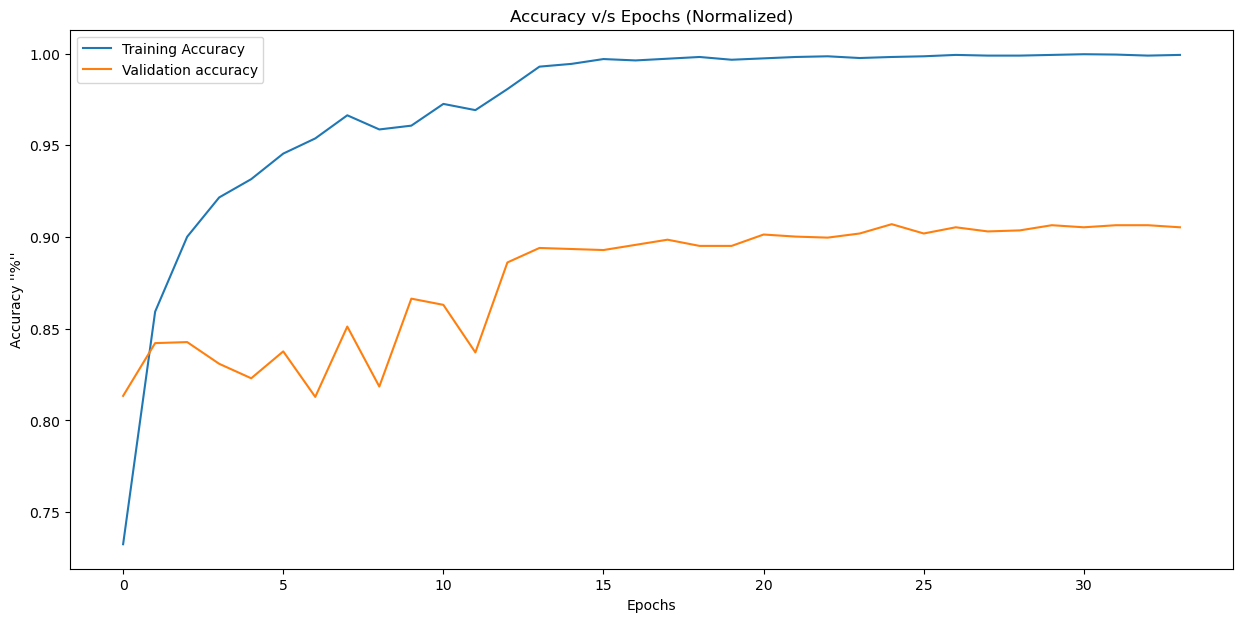

In [12]:
plt.figure(figsize=(15,7))
plt.plot(det1.history['accuracy'])
plt.plot(det1.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel("Accuracy ''%''")
plt.legend(['Training Accuracy','Validation accuracy'])
plt.title('Accuracy v/s Epochs (Normalized)')
plt.savefig('Res_Acc.svg')

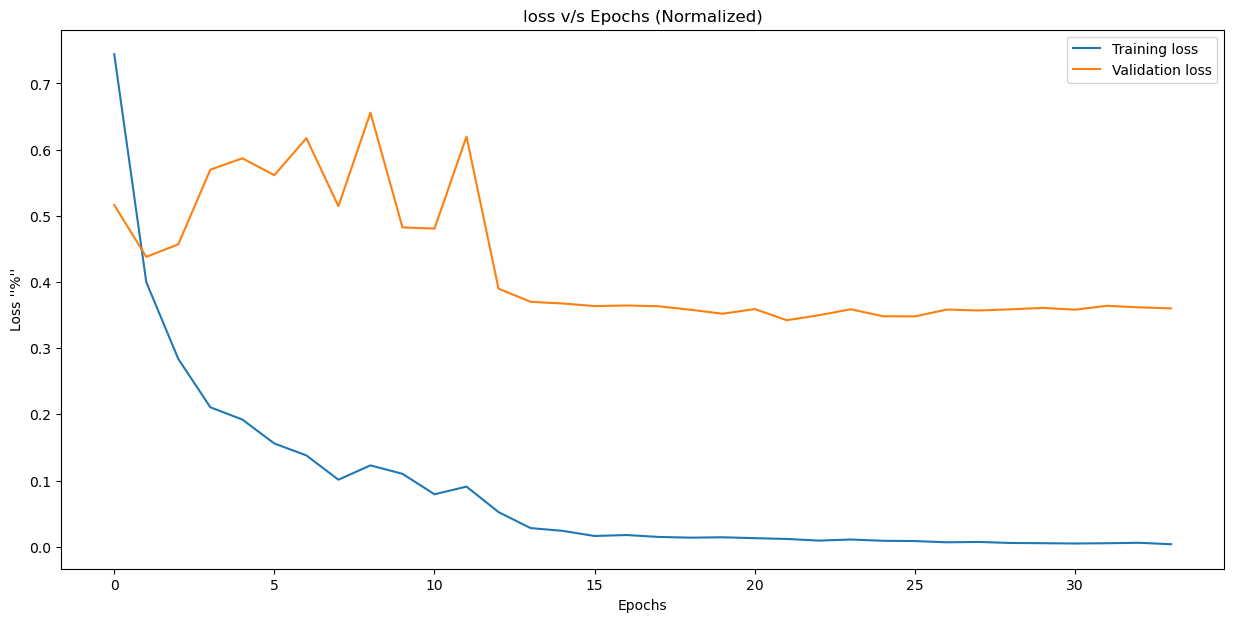

In [13]:
plt.figure(figsize=(15,7))
plt.plot(det1.history['loss'])
plt.plot(det1.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel("Loss ''%''")
plt.legend(['Training loss','Validation loss'])
plt.title('loss v/s Epochs (Normalized)')
plt.savefig('Res_loss.svg')

In [19]:
# det=model.fit(tr,epochs=100,verbose=1,validation_data=te,callbacks=[lr,es,mc])

Epoch 1/100
266/266 [==============================] - 60s 226ms/step - loss: 0.6994 - accuracy: 0.7450 - val_loss: 0.9051 - val_accuracy: 0.6832 - lr: 0.0010
Epoch 2/100
266/266 [==============================] - 63s 236ms/step - loss: 0.6972 - accuracy: 0.7444 - val_loss: 0.8145 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 3/100
266/266 [==============================] - 63s 235ms/step - loss: 0.6942 - accuracy: 0.7453 - val_loss: 1.8906 - val_accuracy: 0.6274 - lr: 0.0010
Epoch 4/100
266/266 [==============================] - 63s 237ms/step - loss: 0.7158 - accuracy: 0.7410 - val_loss: 1.4225 - val_accuracy: 0.6984 - lr: 0.0010
Epoch 5/100
266/266 [==============================] - 64s 240ms/step - loss: 0.7768 - accuracy: 0.7141 - val_loss: 1.2090 - val_accuracy: 0.6359 - lr: 0.0010
Epoch 6/100
266/266 [==============================] - 63s 237ms/step - loss: 0.7521 - accuracy: 0.7186 - val_loss: 1.2762 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 7/100
266/266 [=========================

Text(0.5, 1.0, 'Accuracy v/s Epochs')

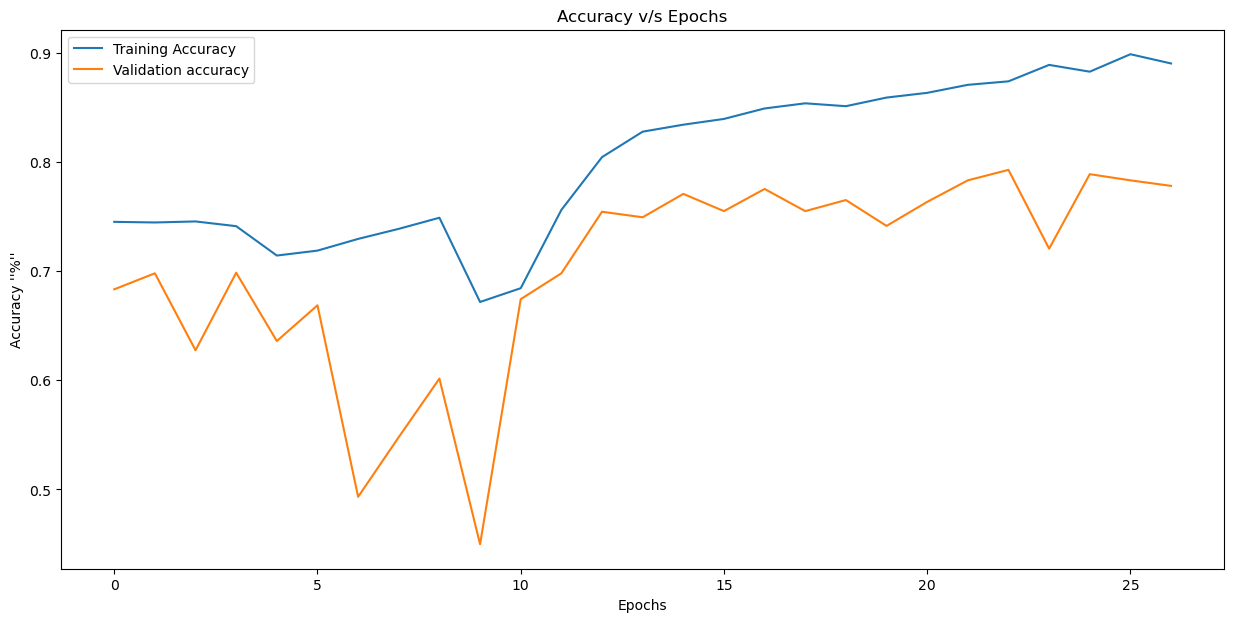

In [92]:
# plt.figure(figsize=(15,7))
# plt.plot(det.history['accuracy'])
# plt.plot(det.history['val_accuracy'])
# plt.xlabel('Epochs')
# plt.ylabel("Accuracy ''%''")
# plt.legend(['Training Accuracy','Validation accuracy'])
# plt.title('Accuracy v/s Epochs')

Text(0.5, 1.0, 'loss v/s Epochs')

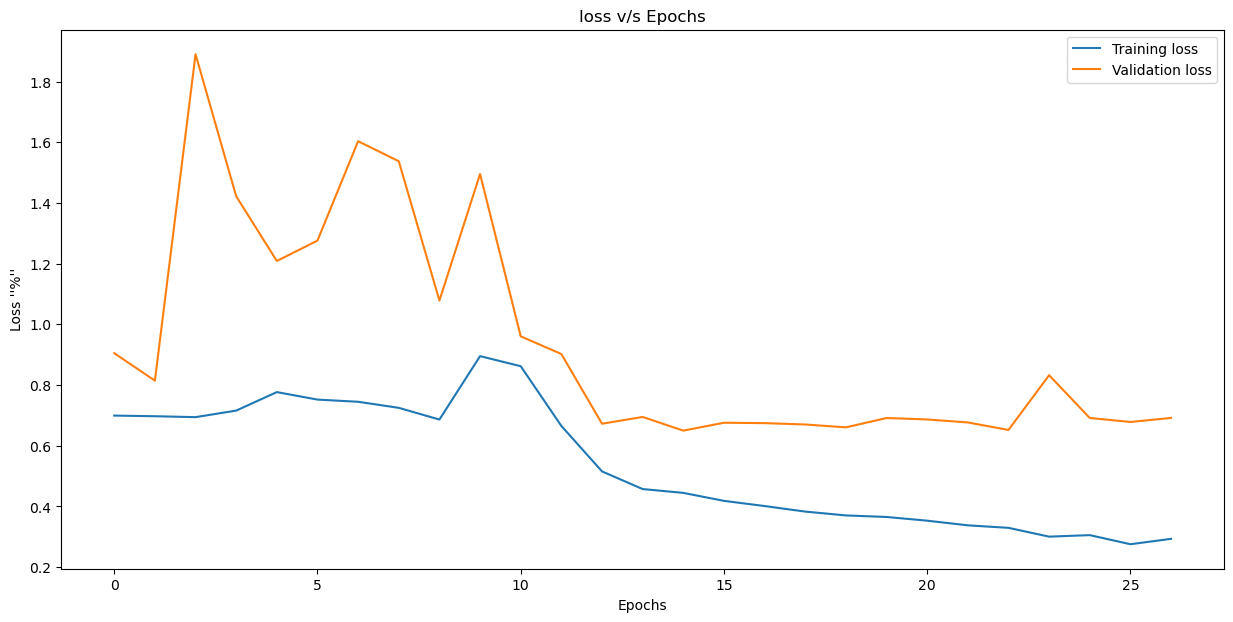

In [91]:
# plt.figure(figsize=(15,7))
# plt.plot(det.history['loss'])
# plt.plot(det.history['val_loss'])
# plt.xlabel('Epochs')
# plt.ylabel("Loss ''%''")
# plt.legend(['Training loss','Validation loss'])
# plt.title('loss v/s Epochs')

In [20]:
# model.save(r'D:\Models\Inception_model_Trash_Classification_end_weights.h5')

In [16]:
model.evaluate(tr)


266/266 [==============================] - 26s 96ms/step - loss: 0.0037 - accuracy: 0.9989


[0.0037053136620670557, 0.9988715648651123]

In [14]:
model.evaluate(te)

89/89 [==============================] - 8s 85ms/step - loss: 0.3245 - accuracy: 0.9205


[0.32445865869522095, 0.9205185770988464]

In [55]:
m2=model
m2.load_weights(r"D:\Models\Inception_model_Trash_Classification_end_weights.h5")

In [30]:
m2.evaluate(tr)
m2.evaluate(te)

89/89 [==============================] - 8s 92ms/step - loss: 0.6498 - accuracy: 0.7706


[0.6498028635978699, 0.7705749869346619]